<a href="https://colab.research.google.com/github/brscn2/deeplearning-for-coders-work/blob/main/ch6_multi_label_%26_image_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from fastai.vision.all import *
path = untar_data(URLs.PASCAL_2007)

In [ ]:
# The data comes in the form of a csv file, so using Pandas for
# inspecting the data

df = pd.read_csv(path/'train.csv')
df.head()

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True


In [ ]:
# !! Lambda functions are not compatible with serialization
# !! therefore if learner to be exported, should define functions

dblock = DataBlock(get_x = lambda r: r['fname'], get_y = lambda r: r['labels'])
dsets = dblock.datasets(df)
dsets.train[0]

('004839.jpg', 'boat')

In [ ]:
def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()

  return train, valid

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter = splitter)
dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=500x333,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
                      0., 0., 0., 0., 0.]))

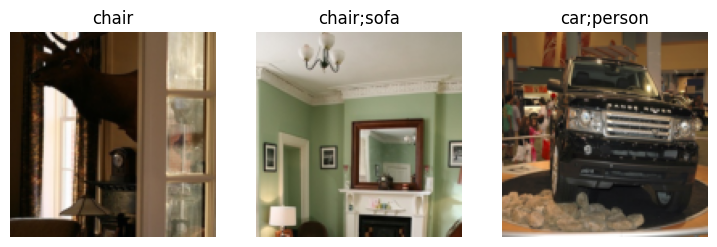

In [ ]:
dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x = get_x,
                   get_y = get_y,
                   splitter = splitter,
                   item_tfms = RandomResizedCrop(128, min_scale=0.35))
dls = dblock.dataloaders(df)
dls.show_batch(nrows=1, ncols=3)

In [ ]:
learn = vision_learner(dls, resnet18)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 123MB/s] 


In [ ]:
x,y = dls.train.one_batch()
activations = learn.model(x)
activations.shape

# Batch size is 64 and there are 20 categories

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [ ]:
activations[0]

In [ ]:
# We can use binary cross entropy loss
def binary_cross_entropy(inputs, targets):
  inputs = inputs.sigmoid()
  return -torch.where(targets==1, inputs, 1-inputs).log().mean()

In [ ]:
# Previous accuracy metric doesn't work, need to change it
def accuracy_multi(inp, targ, threshold=0.5, sigmoid=True):
  if sigmoid:
    inp = inp.sigmoid()
  return ((inp > threshold)==targ.bool()).float().mean()

In [ ]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, threshold=0.2))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 151MB/s] 


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.943294,0.683421,0.231295,00:13
1,0.819570,0.543368,0.288825,00:12
2,0.600042,0.193585,0.827769,00:12
3,0.354169,0.116038,0.949741,00:12


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.132581,0.104127,0.951255,00:15
1,0.115606,0.097262,0.957211,00:15
2,0.098683,0.094850,0.956195,00:15


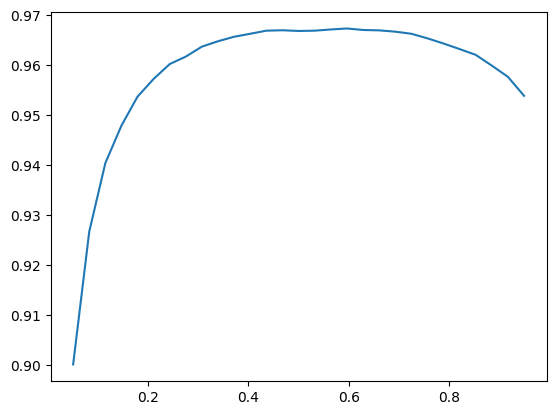

In [ ]:
# Choosing the right value for threshold is important!
preds, targs = learn.get_preds()
xs = torch.linspace(0.05, 0.95, 29)
accs = [accuracy_multi(preds, targs, threshold=i, sigmoid=False) for i in xs]
plt.plot(xs, accs)

In [ ]:
learn = vision_learner(dls, resnet50, metrics=partial(accuracy_multi, threshold=0.6))
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.957956,0.695821,0.739781,00:12
1,0.829554,0.542595,0.844621,00:12
2,0.602706,0.197090,0.959602,00:12
3,0.356459,0.115700,0.960996,00:13


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.129939,0.102350,0.964681,00:15
1,0.114984,0.097438,0.967191,00:15
2,0.100547,0.096139,0.966195,00:14


In [ ]:
# Another problem type : image regression
# calculate the pos. of the center of a persons face (row, col) from image

path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/04.obj'),Path('/root/.fastai/data/biwi_head_pose/15.obj'),Path('/root/.fastai/data/biwi_head_pose/10.obj'),Path('/root/.fastai/data/biwi_head_pose/20.obj'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/22'),Path('/root/.fastai/data/biwi_head_pose/01'),Path('/root/.fastai/data/biwi_head_pose/03.obj'),Path('/root/.fastai/data/biwi_head_pose/07.obj'),Path('/root/.fastai/data/biwi_head_pose/23')...]

In [ ]:
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00118_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00163_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00211_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00239_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00041_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00357_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00131_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00316_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00058_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00292_pose.txt')...]

In [ ]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/22/frame_00163_pose.txt')

In [ ]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

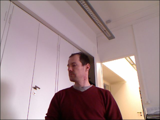

In [ ]:
im.to_thumb(160)

In [ ]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_center(f):
    center = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = center[0] * cal[0][0]/center[2] + cal[0][2]
    c2 = center[1] * cal[1][1]/center[2] + cal[1][2]
    return tensor([c1, c2])
get_center(img_files[0])

tensor([311.6877, 268.2660])

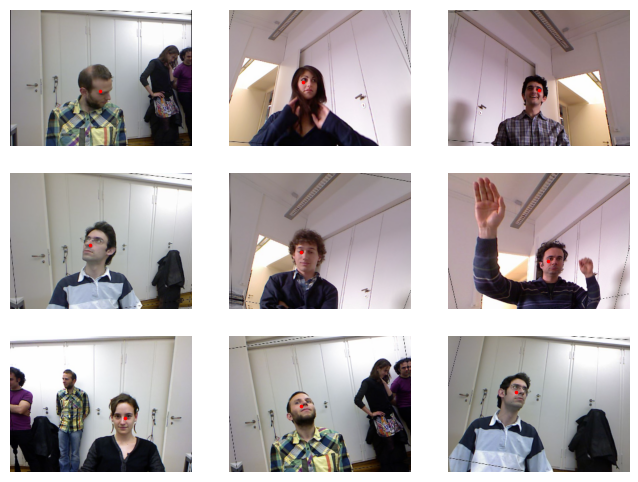

In [ ]:
biwi = DataBlock(blocks = (ImageBlock, PointBlock),
                 get_items = get_image_files,
                 get_y = get_center,
                 splitter = FuncSplitter(lambda o: o.parent.name=='13'),
                 batch_tfms = [*aug_transforms(size=(240,320)),
                               Normalize.from_stats(*imagenet_stats)])
dls = biwi.dataloaders(path)
dls.show_batch(max_n = 9, figsize=(8,6))

In [ ]:
# Coordinates are rescaled to be within -1 and 1 by PyTorch and fastai
learn = vision_learner(dls, resnet18, y_range=(-1,1))

## In the background, sigmoid_range is used when we specify y_range
# def sigmoid_range(x, lo, hi): return sigmoid(x) * (hi - lo) + lo

dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(valley=0.0010000000474974513)

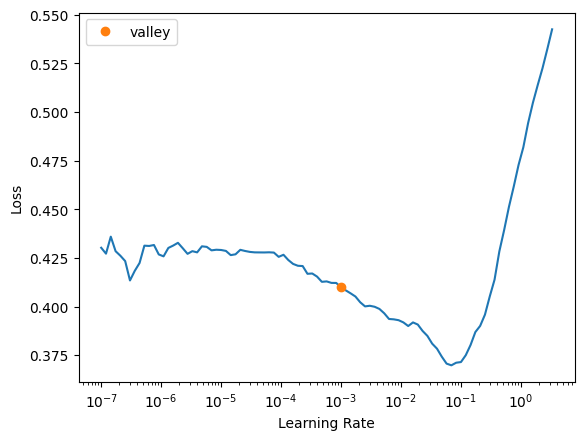

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,time
0,0.002196,0.000416,01:04
1,0.002017,0.000093,01:03
2,0.001773,0.000167,01:03
3,0.001537,0.000105,01:03
4,0.001565,0.000158,01:03


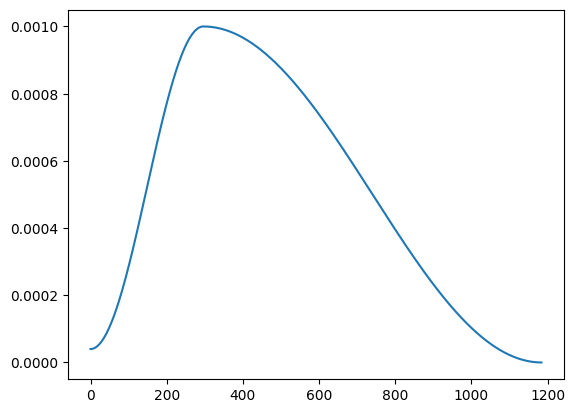

In [ ]:
plt.plot(learn.recorder.lrs)

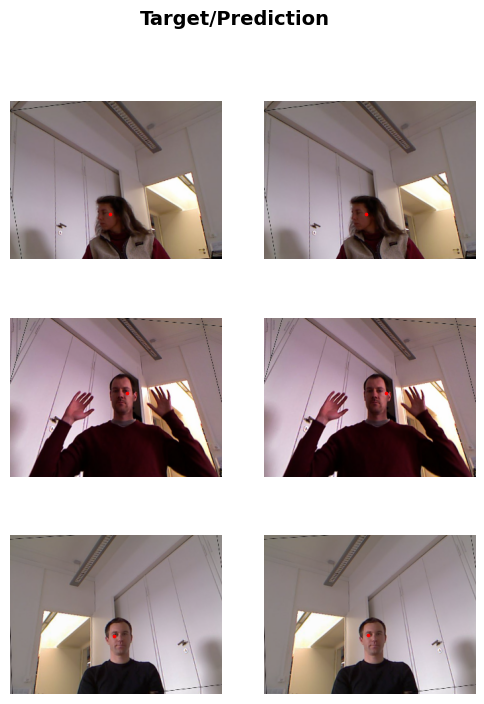

In [ ]:
learn.show_results(ds_idx=0, max_n=3, figsize=(6,8))